In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, RealData
from sklearn.metrics import r2_score

plt.style.use('wfk')

In [3]:
df_dG_path = "../Outputs/LFER Data/dGData_w_error.xlsx"
df_dG = pd.read_excel(df_dG_path)

display(df_dG)

,Membrane Composition,Cation,ML Model,Ion-Ligand dG ML [kcal/mol],StdDev,Ion-LFM dG Measured [kcal/mol],StdDev.1,Last Updated
0,50mol% 4VP,Li+,XGBoost,1.638664,0.208470,-1.537827,0.037387,2025-02-25
1,50mol% 4VP,Mg2+,XGBoost,1.134809,0.214808,-1.572624,0.220131,2025-02-25
2,50mol% 4VP,Mn2+,XGBoost,0.845458,0.077300,-1.792730,0.016983,2025-02-25
3,50mol% 4VP,Co2+,XGBoost,-0.127930,0.033733,-2.459695,0.032378,2025-02-25
4,50mol% 4VP,Ni2+,XGBoost,-0.374170,0.020430,-2.788169,0.014936,2025-02-25
5,50mol% 4VP,Cu2+,XGBoost,-0.544593,0.014072,-3.200267,0.044774,2025-02-25


### Figure 3a - LFER

In [4]:
def linear_func(p, x):
    m, c = p
    return m * x + c

In [5]:
c_dict = {'Li+': 'tab:blue', 'K+': 'tab:green', 'Ni2+': 'tab:red', 'Mg2+': 'tab:purple', 'Cu2+': 'tab:orange',
          'Mn2+': 'tab:brown', 'Na+': 'tab:pink', 'Co2+': 'tab:gray'}

plot_order = ['Li+', 'Ni2+', 'Mg2+', 'K+', 'Cu2+', 'Mn2+', 'Na+', 'Co2+']

In [6]:
ions = df_dG['Cation']

x = df_dG['Ion-Ligand dG ML [kcal/mol]']
x_err = df_dG['StdDev']

y = df_dG['Ion-LFM dG Measured [kcal/mol]']
y_err = df_dG['StdDev.1']

zipped = list(zip(ions, x, x_err, y, y_err))
zipped = sorted(zipped, key=lambda x: plot_order.index(x[0]))
print(zipped)

[('Li+', 1.638664, 0.20847, -1.5378272084053173, 0.03738679168121919), ('Ni2+', -0.37417, 0.02043, -2.788169177406647, 0.014936075833425167), ('Mg2+', 1.134809, 0.214808, -1.5726238078755943, 0.22013096474542995), ('Cu2+', -0.544593, 0.014072, -3.2002673007619817, 0.04477418419541098), ('Mn2+', 0.845458, 0.0773, -1.7927298844478718, 0.01698303972623493), ('Co2+', -0.12793, 0.033733, -2.459694959823574, 0.0323778484498184)]


In [7]:
# Fit LFER 1 using scipy.odr packages
data = RealData(x, y, sx=x_err, sy=y_err)
odr = ODR(data, Model(linear_func), beta0=[1., 0.])
regr = odr.run()
slope, intercept = regr.beta
slope_sd, intercept_sd = regr.sd_beta

# calculate 95% CI for slope and intercept
slope_95_high = slope + 1.96 * slope_sd/np.sqrt(len(x))
slope_95_low = slope - 1.96 * slope_sd/np.sqrt(len(x))
int_95_high = intercept + 1.96 * intercept_sd/np.sqrt(len(x))
int_95_low = intercept - 1.96 * intercept_sd/np.sqrt(len(x))

# calculate R2 and RMSE
lfer_R2 = r2_score(y, slope * x + intercept)
lfer_RMSE = np.sqrt(np.mean((y - (slope * x + intercept))**2))

lfer_label = f'LFER\nm = {slope:.2f} +/- {slope_sd:.2f}\nb = {intercept:.2f} +/- {intercept_sd:.2f}\nRMSE = {lfer_RMSE:.3f} kcal/mol\nR² = {lfer_R2:.2f}' 
print(lfer_label)

LFER
m = 0.92 +/- 0.18
b = -2.48 +/- 0.08
RMSE = 0.264 kcal/mol
R² = 0.83


Text(0, 0.5, 'Observed $\\Delta G_{Ion-LFM}$ [kcal/mol]')

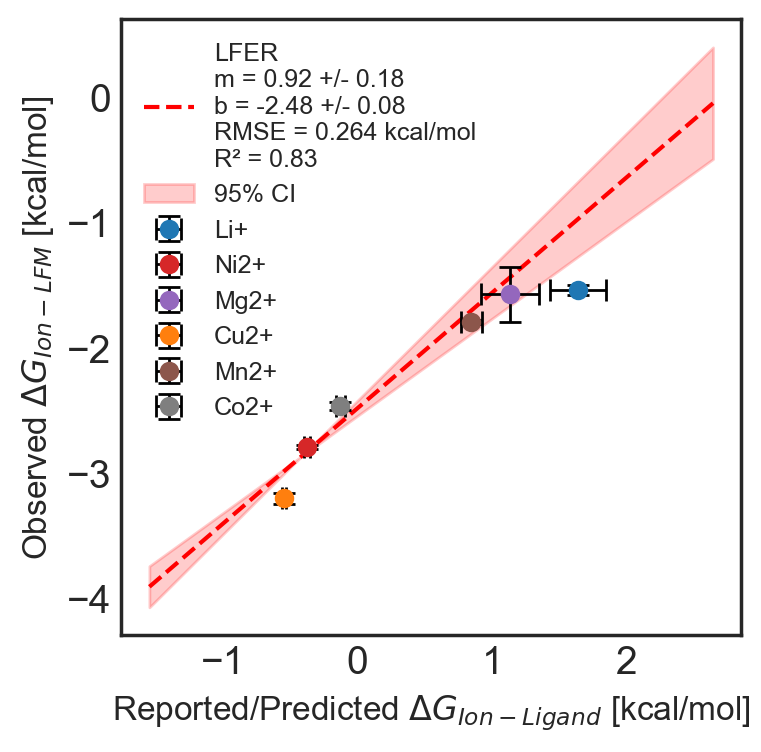

In [8]:
fig, axs = plt.subplots(1,1,figsize=(4,4), dpi=200)

for z in zipped:
    c = c_dict[z[0]]
    axs.errorbar(z[1], z[3], xerr=z[2], yerr=z[4], fmt='o', label=z[0],
                 ecolor='black', capsize=4, capthick=1, elinewidth=1, c=c)
    
x_fit = np.linspace(min(x) - 1, max(x) + 1, 100)
y_fit = linear_func(regr.beta, x_fit)

axs.plot(x_fit, y_fit, 'r--', label=lfer_label, zorder=0)

axs.fill_between(x_fit,
                 linear_func([slope_95_low, int_95_low], x_fit),
                 linear_func([slope_95_high, int_95_high], x_fit), 
                 color='red', alpha=0.2, zorder=0, label='95% CI')

axs.legend(fontsize=9)
axs.set_xlabel(r'Reported/Predicted $\Delta G_{Ion-Ligand}$ [kcal/mol]', fontsize=12)
axs.set_ylabel(r'Observed $\Delta G_{Ion-LFM}$ [kcal/mol]', fontsize=12)